In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Audio
%matplotlib inline
plt.rcParams['figure.dpi']= 150

First, we define parameters:

In [2]:
# Transport parameters
s_perm = 0.1
u_perm = 0.1
w_D_perm = 0.1
w_C_perm = 0.1
S_input = 0.1
U_input = 1
osm_input = 2

# discretization
N = 10
dx = 1/N

Now, we define the difference quotient operator

In [3]:
def diff_x(y): 
    n = len(y)-1
    diff = np.zeros(n)
    for l in range(n):
        diff[l] = (y[l+1]-y[l])/dx
    
    return diff

def avg(y):
    n = len(y)-1
    average = np.zeros(n)
    for l in range(n):
        average[l] = (y[l+1]+y[l])/2
    
    return average

In [4]:
def res(y):
    S = y[:(N+1)].copy()
    U = y[(N+1):2*(N+1)].copy()
    q_D = y[2*(N+1):3*(N+1)].copy()
    q_C = y[3*(N+1):4*(N+1)].copy()
    q_A = y[4*(N+1):5*(N+1)].copy()
    q_out = y[5*(N+1):6*(N+1)].copy()
    S_avg = avg(S)
    U_avg = avg(U)
    q_D_avg = avg(q_D)
    q_C_avg = avg(q_C)
    q_A_avg = avg(q_A)
    q_out_avg = avg(q_out)

    S_0 = S[-1] - S_avg
    U_0 = U[-1] - U_avg
    q_0 = q_out_avg - q_C_avg - q_A_avg - q_D_avg

    residue = np.zeros(6*(N+1))
    res_s = residue[:(N+1)]
    res_u = residue[(N+1):2*(N+1)]
    res_D = residue[2*(N+1):3*(N+1)]
    res_C = residue[3*(N+1):4*(N+1)]
    res_A = residue[4*(N+1):5*(N+1)]
    res_out = residue[5*(N+1):6*(N+1)]

    res_s[0] = S[-1] + S_input
    res_s[1:] = diff_x(S) + s_perm*(
        (S_avg/q_A_avg) - (S_0/q_0)
    )
    res_u[0] = U[0] - U_input
    res_u[1:] = diff_x(U) + u_perm*(
        (U_avg/q_C_avg) - (U_0/q_0)
    )
    res_D[0] = q_D[0] - 2*S_input/osm_input
    res_D[1:] = diff_x(q_D) + w_D_perm*(
        (2*S_0 + U_0)/q_0 - 2*S_input/q_D_avg 
    )
    res_C[0] = q_C[0] - U_input/osm_input
    res_C[1:] = diff_x(q_C) + w_C_perm*(
        (2*S_0 + U_0)/q_0 - U_avg/q_C_avg 
    )
    res_A[0] = q_A[-1] + q_D[-1]
    res_A[1:] = diff_x(q_A)
    res_out[0] = q_C[-1] - q_out[-1]
    res_out[1:] = diff_x(q_out)

    return residue

Finally, we put everything together:

In [5]:
# Transport parameters
s_perm = .1
u_perm = 0.1
w_D_perm = .1
w_C_perm = .1

S_input = .1
U_input = 2
osm_input = 2

# discretization
N = 50
dx = 1/N


#Initial guess
y_init = np.zeros(6*(N+1))
S_init = y_init[:(N+1)]
U_init = y_init[(N+1):2*(N+1)]
q_D_init = y_init[2*(N+1):3*(N+1)]
q_C_init = y_init[3*(N+1):4*(N+1)]
q_A_init = y_init[4*(N+1):5*(N+1)]
q_out_init = y_init[5*(N+1):6*(N+1)]
for n in range(N+1):
    S_init[n] = 0.5*(n/N - 1)*S_input
    U_init[n] = (1 - 0.5*n/N)*U_input
    q_D_init[n] = 2*(1 - 0.5*n/N)*S_input/osm_input
    q_C_init[n] = (1 - 0.5*n/N)*U_input/osm_input
q_A_init[:] = - q_D_init[-1].copy()
q_out_init[:] = q_C_init[-1].copy()

y = fsolve(res,y_init,maxfev=500*6*(N+1))
S = y[:(N+1)]
U = y[(N+1):2*(N+1)]
q_D = y[2*(N+1):3*(N+1)]
q_C = y[3*(N+1):4*(N+1)]
q_A = y[4*(N+1):5*(N+1)]
q_out = y[5*(N+1):6*(N+1)]
S_0 = S[-1] - avg(S)
U_0 = U[-1] - avg(U)
q_0 = avg(q_out) - avg(q_C) - avg(q_A) - avg(q_D)
osm_0 = (2*S_0+U_0)/q_0
osm_C = U/q_C
osm_D = 2*S_input/q_D

In [196]:
y[:]=np.load('./4fluxes_demo.npy')

In [251]:
y_init[:] = y.copy()

# Transport parameters
# demo: 2,4,10,10,0.1
s_perm = .5
u_perm = .5
w_D_perm = 10
w_C_perm = 10
S_input = 1
U_input = 2
osm_input = 2

y[:] = fsolve(res,y_init,maxfev=500*6*(N+1))
q_0 = avg(q_out) - avg(q_C) - avg(q_A) - avg(q_D)
S_0 = S[-1] - avg(S)
U_0 = U[-1] - avg(U)
osm_0 = (2*S_0+U_0)/q_0
osm_C = U/q_C
osm_D = 2*S_input/q_D
osm_A = 2*S/q_A

<function matplotlib.pyplot.show(close=None, block=None)>

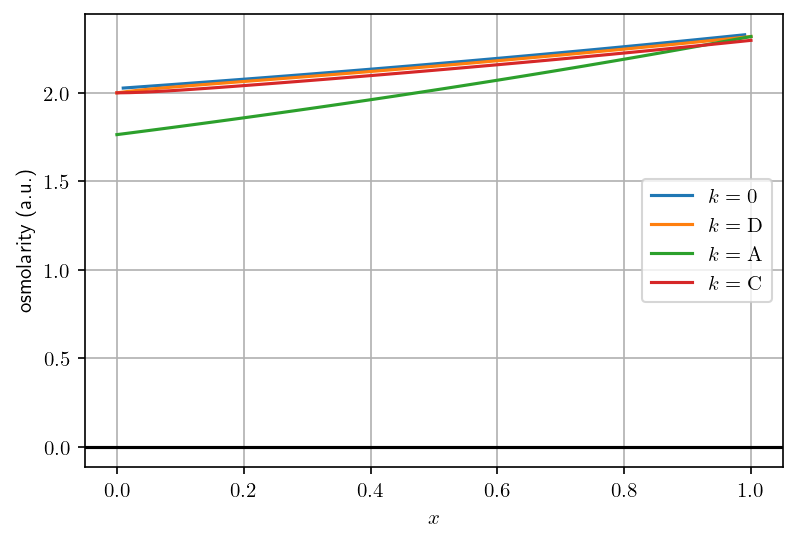

In [252]:
# Plotting osmolarity
x = np.linspace(0,1,num=N+1)
x_avg = np.linspace(dx/2,1-dx/2,num=N)
compartments = ['0','\mathrm{D}','\mathrm{A}','\mathrm{C}']
osm = [osm_0,osm_D,osm_A,osm_C]

fig, ax = plt.subplots()
plt.rcParams['text.usetex'] = True
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
for k in range(4):
    if k==0:
        ax.plot(x_avg,osm[0],label=r'$k={}$'.format(compartments[k]))
    else:
        ax.plot(x,osm[k],label=r'$k={}$'.format(compartments[k]))
ax.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"osmolarity (a.u.)")
plt.show

In [706]:
end_osm_0 = np.zeros((12,12))
end_osm_C = np.zeros((12,12))
end_osm_D = np.zeros((12,12))
y[:] = np.load('./4fluxes_1nephron.npy')

y_init[:] = y.copy()
# Transport parameters
for i in range(12):
    for j in range(12):
        u_perm = .1*(i+1)
        # if (i%2)==0:
        s_perm = .1*(j+1)
        # else:
            # s_perm = .1*(10-j)
        w_D_perm = 10
        w_C_perm = 10
        S_input = 1
        U_input = 2
        osm_input = 2

        y[:] = fsolve(res,y_init,maxfev=500*6*(N+1))
        q_0 = avg(q_out) - avg(q_C) - avg(q_A) - avg(q_D)
        S_0 = S[-1] - avg(S)
        U_0 = U[-1] - avg(U)
        end_osm_0[i,j] = (2*S_0[-1]+U_0[-1])/q_0[-1]
        end_osm_C[i,j] = U[-1]/q_C[-1]
        end_osm_D[i,j] = 2*S_input/q_D[-1]

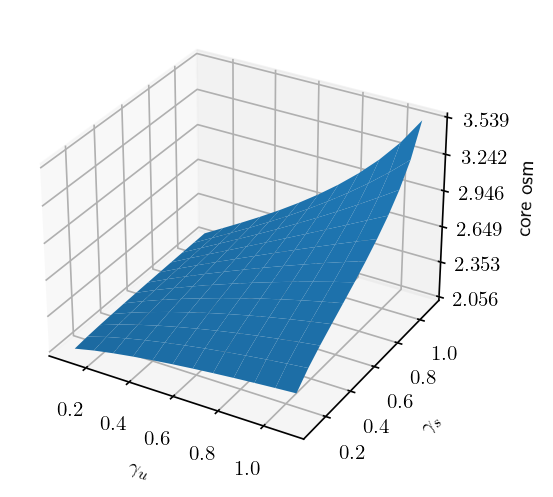

In [669]:
# Plotting end osmolarity against u_perm,s_perm
from matplotlib.ticker import LinearLocator
u_space = np.linspace(0.1,1.1,num=12)
s_space = np.linspace(0.1,1.1,num=12)
u_space, s_space = np.meshgrid(u_space, s_space)

ax = plt.figure().add_subplot(projection='3d')

surf = ax.plot_surface(u_space,s_space,end_osm_0)
plt.rcParams['text.usetex'] = True
plt.xlabel(r"$\gamma_u$")
plt.ylabel(r"$\gamma_s$")
ax.zaxis.set_major_locator(LinearLocator(6))
ax.set_zlabel(r"core osm")
plt.show()

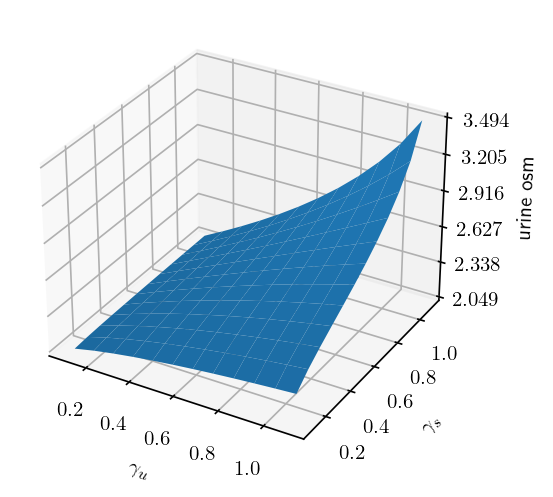

In [670]:
ax = plt.figure().add_subplot(projection='3d')

surf = ax.plot_surface(u_space,s_space,end_osm_C)
plt.rcParams['text.usetex'] = True
plt.xlabel(r"$\gamma_u$")
plt.ylabel(r"$\gamma_s$")
ax.set_zlabel(r"urine osm")
ax.zaxis.set_major_locator(LinearLocator(6))
plt.show()

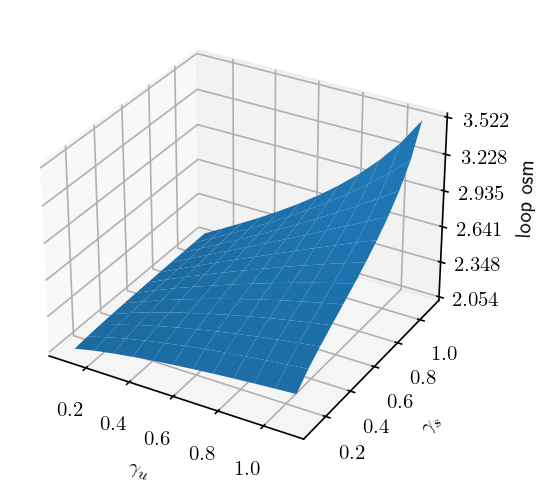

In [707]:
ax = plt.figure().add_subplot(projection='3d')

surf = ax.plot_surface(u_space,s_space,end_osm_D)
plt.rcParams['text.usetex'] = True
plt.xlabel(r"$\gamma_u$")
plt.ylabel(r"$\gamma_s$")
ax.set_zlabel(r"loop osm")
ax.zaxis.set_major_locator(LinearLocator(6))
plt.show()

In [680]:
y[:] = np.load('./4fluxes_1nephron_max.npy')
y_init[:] = y.copy()

# Transport parameters
# demo: 2,4,10,10,0.1
s_perm = 1.2
u_perm = 1.2
w_D_perm = 10
w_C_perm = 10
S_input = 1
U_input = 2
osm_input = 2

y[:] = fsolve(res,y_init,maxfev=500*6*(N+1))
q_0 = avg(q_out) - avg(q_C) - avg(q_A) - avg(q_D)
S_0 = S[-1] - avg(S)
U_0 = U[-1] - avg(U)
osm_0 = (2*S_0+U_0)/q_0
osm_C = U/q_C
osm_D = 2*S_input/q_D
osm_A = 2*S/q_A

<function matplotlib.pyplot.show(close=None, block=None)>

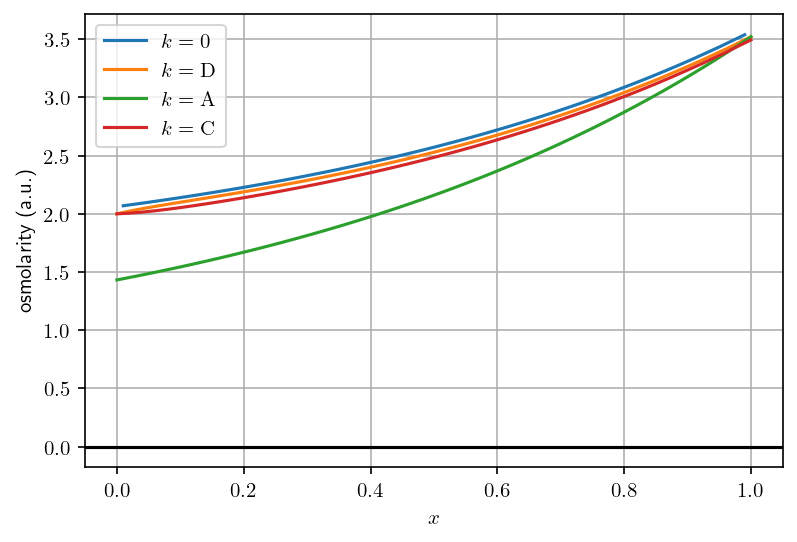

In [681]:
# Plotting osmolarity
x = np.linspace(0,1,num=N+1)
x_avg = np.linspace(dx/2,1-dx/2,num=N)
compartments = ['0','\mathrm{D}','\mathrm{A}','\mathrm{C}']
osm = [osm_0,osm_D,osm_A,osm_C]

fig, ax = plt.subplots()
plt.rcParams['text.usetex'] = True
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
for k in range(4):
    if k==0:
        ax.plot(x_avg,osm[0],label=r'$k={}$'.format(compartments[k]))
    else:
        ax.plot(x,osm[k],label=r'$k={}$'.format(compartments[k]))
ax.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"osmolarity (a.u.)")
plt.show

In [684]:
y[:] = np.load('./4fluxes_1nephron_max.npy')
y_init[:] = y.copy()

output_osm_0 = np.zeros(14)
output_osm_C = np.zeros(14)
output_osm_D = np.zeros(14)

# Transport parameters
for n in range(14):
    s_perm = 1.2
    u_perm = 1.2
    w_D_perm = 10
    w_C_perm = 10
    S_input = 0.3 + n*0.1
    U_input = 2
    osm_input = 2

    y[:] = fsolve(res,y_init,maxfev=500*6*(N+1))
    q_0 = avg(q_out) - avg(q_C) - avg(q_A) - avg(q_D)
    S_0 = S[-1] - avg(S)
    U_0 = U[-1] - avg(U)
    output_osm_0[n] = (2*S_0[-1]+U_0[-1])/q_0[-1]
    output_osm_C[n] = U[-1]/q_C[-1]
    output_osm_D[n] = 2*S_input/q_D[-1]

<function matplotlib.pyplot.show(close=None, block=None)>

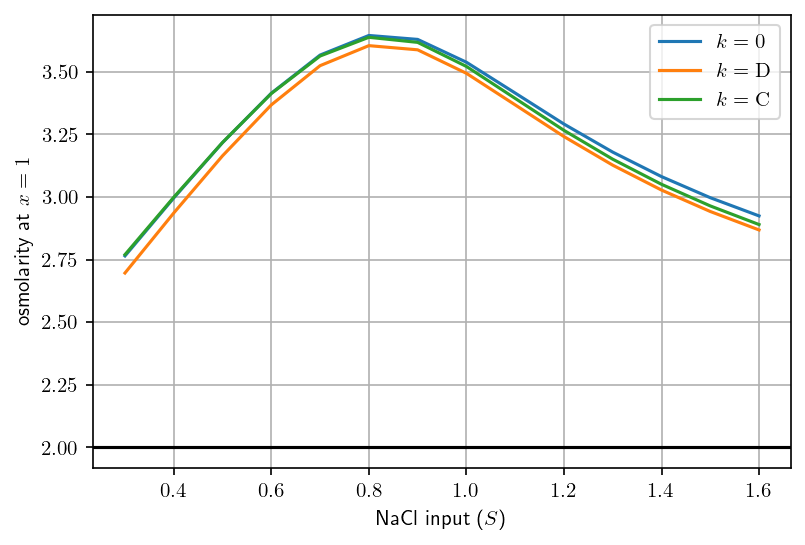

In [687]:
# Plotting osmolarity
n = np.linspace(0.3,1.6,num=14)
compartments = ['0','\mathrm{D}','\mathrm{C}']
osm = [output_osm_0,output_osm_C,output_osm_D]

fig, ax = plt.subplots()
plt.rcParams['text.usetex'] = True
ax.grid(True, which='both')
ax.axhline(y=2, color='k')
for k in range(3):
    ax.plot(n,osm[k],label=r'$k={}$'.format(compartments[k]))
ax.legend()
plt.xlabel(r"NaCl input ($S$)")
plt.ylabel(r"osmolarity at $x=1$")
plt.show